# Simple Planar SLAM Example

GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

Simple robotics example using odometry measurements and bearing-range (laser) measurements
Author: Alex Cunningham (C++), Kevin Deng & Frank Dellaert (Python)

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/examples/PlanarSLAMExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates a basic Simultaneous Localization and Mapping (SLAM) problem in 2D using GTSAM.

**What is GTSAM?**
GTSAM (Georgia Tech Smoothing and Mapping) is a library that implements factor graph-based optimization. It's widely used in robotics for problems like SLAM, Structure from Motion (SfM), and sensor fusion.

**What is a Factor Graph?**
A factor graph is a graphical model that represents the probabilistic relationships between unknown variables (like robot poses and landmark positions) and measurements (like odometry or sensor readings). Optimization in GTSAM involves finding the most likely configuration of variables given the measurements and their associated uncertainties (noise).

**This Example:**
We'll simulate a robot moving in a 2D plane. The robot has:
1.  **Odometry:** Measurements of its own motion (how far it moved between steps).
2.  **Bearing-Range Sensor:** A sensor (like a simple laser scanner) that measures the bearing (angle) and range (distance) to landmarks.

We'll build a factor graph representing the robot's poses, landmark positions, odometry measurements, and bearing-range measurements. Then, we'll use GTSAM to optimize the graph and find the best estimate of the robot's trajectory and landmark locations.

## 1. Setup and Imports

First, we need to import the necessary libraries: `gtsam` itself and `numpy` for numerical operations.

In [15]:
# Install GTSAM from pip if running in Google Colab
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass # Not in Colab

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import graphviz

import gtsam
import gtsam.utils.plot as gp

# We can use shorthand symbols for variable keys
# X(i) represents the i-th pose variable
# L(j) represents the j-th landmark variable
from gtsam.symbol_shorthand import L, X

## 2. Define Noise Models

Real-world measurements are always noisy. In GTSAM, we model this noise using Gaussian noise models. We need to define the uncertainty (standard deviation) for each type of measurement:

*   **Prior Noise:** Uncertainty about the very first pose of the robot. We often assume we know the starting position reasonably well, but not perfectly.
*   **Odometry Noise:** Uncertainty in the robot's movement measurements (e.g., wheel encoders). Assumed to be Gaussian noise on the change in x, y, and theta.
*   **Measurement Noise:** Uncertainty in the bearing-range sensor readings. Assumed to be Gaussian noise on the bearing and range measurements.

In [17]:
# Create noise models with specified standard deviations (sigmas).
# gtsam.noiseModel.Diagonal.Sigmas takes a numpy array of standard deviations.

# Prior noise on the first pose (x, y, theta) - sigmas = [0.3m, 0.3m, 0.1rad]
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
# Odometry noise (dx, dy, dtheta) - sigmas = [0.2m, 0.2m, 0.1rad]
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
# Measurement noise (bearing, range) - sigmas = [0.1rad, 0.2m]
MEASUREMENT_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.2]))

## 3. Build the Factor Graph

Now, we'll create the factor graph step-by-step.

First, create an empty nonlinear factor graph.

In [18]:
# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

### 3.1 Variable Keys

We need unique keys to identify each unknown variable (robot poses and landmark positions) in the graph. 
We'll have 3 robot poses $(x_1, x_2, x_3)$ and 2 landmarks $(l_1, l_2)$. We will just use `X(1)`..`L(2)` in the code, using the `X(i)` and `L(j)` shorthand imported earlier. Note here we can use base 1 indexing but you can use any integer, and numbering does not have to be consecutive.

### 3.2 Add a Prior Factor

To "anchor" the graph, we add a prior factor on the first pose $x_1$. This represents our initial belief about where the robot started. We assume it started at the origin (0, 0, 0) with the uncertainty defined by `PRIOR_NOISE`.

A `PriorFactorPose2` connects the single pose variable $x_1$ to a known pose (`gtsam.Pose2(0,0,0)`) with a specific noise model.

In [19]:
# Add a prior on pose X(1) at the origin.
# A prior factor consists of a mean (gtsam.Pose2) and a noise model.
graph.add(gtsam.PriorFactorPose2(X(1), gtsam.Pose2(0.0, 0.0, 0.0), PRIOR_NOISE))

### 3.3 Add Odometry Factors

Next, we add factors representing the robot's movement based on odometry measurements. We assume the robot moved approximately 2 units forward in the x-direction between each pose.

A `BetweenFactorPose2` connects two consecutive poses (e.g., $x_1$ and $x_2$) and represents the measured relative motion between them (`gtsam.Pose2(2.0, 0.0, 0.0)`) with its associated noise (`ODOMETRY_NOISE`).

In [20]:
# Add odometry factors between X(1),X(2) and X(2),X(3), respectively.
# The measurement is the relative motion: Pose2(dx, dy, dtheta).

# Between X(1) and X(2): Move forward 2m
graph.add(gtsam.BetweenFactorPose2(X(1), X(2), gtsam.Pose2(2.0, 0.0, 0.0), ODOMETRY_NOISE))
# Between X(2) and X(3): Move forward 2m
graph.add(gtsam.BetweenFactorPose2(X(2), X(3), gtsam.Pose2(2.0, 0.0, 0.0), ODOMETRY_NOISE))

### 3.4 Add Measurement Factors

Now, add factors representing the bearing-range measurements from the robot's poses to the landmarks.

A `BearingRangeFactor2D` connects a pose variable (e.g., $x_1$) and a landmark variable (e.g., $l_1$). It includes the measured bearing (`gtsam.Rot2`) and range (distance), along with the measurement noise (`MEASUREMENT_NOISE`).

We have three measurements:
*   From $x_1$ to $l_1$: Bearing 45 degrees, Range sqrt(8)
*   From $x_2$ to $l_1$: Bearing 90 degrees, Range 2.0
*   From $x_3$ to $l_2$: Bearing 90 degrees, Range 2.0

In [21]:
# Add Range-Bearing measurements to two different landmarks L(1) and L(2).
# Measurements are Bearing (gtsam.Rot2) and Range (float).

# From X(1) to L(1)
graph.add(gtsam.BearingRangeFactor2D(X(1), L(1), gtsam.Rot2.fromDegrees(45), np.sqrt(4.0+4.0), MEASUREMENT_NOISE))
# From X(2) to L(1)
graph.add(gtsam.BearingRangeFactor2D(X(2), L(1), gtsam.Rot2.fromDegrees(90), 2.0, MEASUREMENT_NOISE))
# From X(3) to L(2)
graph.add(gtsam.BearingRangeFactor2D(X(3), L(2), gtsam.Rot2.fromDegrees(90), 2.0, MEASUREMENT_NOISE))

### 3.5 Inspect the Graph

We can print the factor graph to see a summary of the variables and factors we've added.

In [22]:
# Print the graph. This shows the factors and the variables they connect.
print("Factor Graph:\n{}".format(graph))

Factor Graph:
NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on x1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.3; 0.3; 0.1];

Factor 1: BetweenFactor(x1,x2)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 2: BetweenFactor(x2,x3)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 3: BearingRangeFactor
Factor 3:   keys = { x1 l1 }
  noise model: diagonal sigmas [0.1; 0.2];
ExpressionFactor with measurement: bearing : 0.785398163
range  2.82842712

Factor 4: BearingRangeFactor
Factor 4:   keys = { x2 l1 }
  noise model: diagonal sigmas [0.1; 0.2];
ExpressionFactor with measurement: bearing : 1.57079633
range  2

Factor 5: BearingRangeFactor
Factor 5:   keys = { x3 l2 }
  noise model: diagonal sigmas [0.1; 0.2];
ExpressionFactor with measurement: bearing : 1.57079633
range  2




## 4. Create Initial Estimate

Factor graph optimization is an iterative process that needs an initial guess (initial estimate) for the values of all unknown variables. The closer the initial estimate is to the true solution, the faster and more reliably the optimizer will converge.

Here, we create a `gtsam.Values` object and deliberately insert slightly *inaccurate* initial estimates for the poses and landmark positions. This demonstrates that the optimizer can correct for errors in the initial guess.

In [23]:
# Create (deliberately inaccurate) initial estimate.
# gtsam.Values is a container mapping variable keys to their estimated values.
initial_estimate = gtsam.Values()

# Insert initial guesses for poses (Pose2: x, y, theta)
initial_estimate.insert(X(1), gtsam.Pose2(-0.25, 0.20, 0.15))
initial_estimate.insert(X(2), gtsam.Pose2(2.30, 0.10, -0.20))
initial_estimate.insert(X(3), gtsam.Pose2(4.10, 0.10, 0.10))

# Insert initial guesses for landmarks (Point2: x, y)
initial_estimate.insert(L(1), gtsam.Point2(1.80, 2.10))
initial_estimate.insert(L(2), gtsam.Point2(4.10, 1.80))

# Print the initial estimate
print("Initial Estimate:\n{}".format(initial_estimate))

Initial Estimate:
Values with 5 values:
Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.8;
	2.1
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.1;
	1.8
]

Value x1: (gtsam::Pose2)
(-0.25, 0.2, 0.15)

Value x2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value x3: (gtsam::Pose2)
(4.1, 0.1, 0.1)




Now that we have an initial estimate we can also visualize the graph:

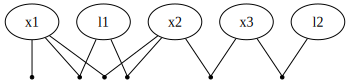

In [24]:
display(graphviz.Source(graph.dot(initial_estimate)))

## 5. Optimize the Factor Graph

Now, we use an optimizer to find the variable configuration that best fits all the factors (measurements) in the graph, starting from the initial estimate.

We'll use the Levenberg-Marquardt (LM) algorithm, a standard non-linear least-squares optimizer.

1.  Create LM parameters (`gtsam.LevenbergMarquardtParams`). We'll use the defaults.
2.  Create the optimizer instance, providing the graph, initial estimate, and parameters.
3.  Run the optimization by calling `optimizer.optimize()`.

In [25]:
# Optimize using Levenberg-Marquardt optimization.
# The optimizer accepts optional parameters, but we'll use the defaults here.
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

# Perform the optimization
result = optimizer.optimize()

# Print the final optimized result
# This gtsam.Values object contains the most likely estimates for all variables.
print("\nFinal Result:\n{}".format(result))


Final Result:
Values with 5 values:
Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2;
	2
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4;
	2
]

Value x1: (gtsam::Pose2)
(-5.72151617e-16, -2.6221043e-16, -8.93525825e-17)

Value x2: (gtsam::Pose2)
(2, -5.76036948e-15, -6.89367166e-16)

Value x3: (gtsam::Pose2)
(4, -1.0618198e-14, -6.48560093e-16)




The code below visualizes the optimized poses and landmarks in 2D. It uses GTSAM's plotting utilities to plot the robot's trajectory (poses) and the estimated positions of the landmarks. The poses are represented as coordinate frames indicating the robot's orientation, while the landmarks are plotted as blue points. The aspect ratio is set to ensure equal scaling for both axes.

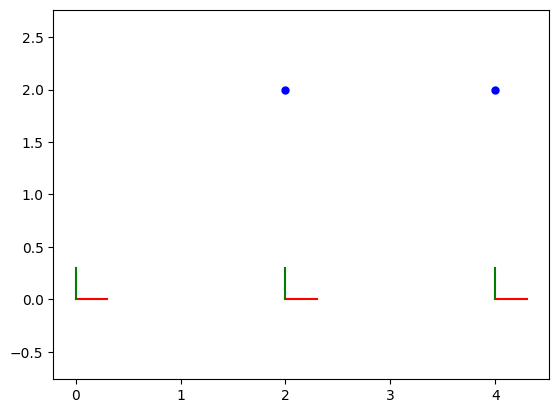

In [26]:
fig = plt.figure(1)
axes = fig.add_subplot()
axes = fig.axes[0]

# Plot 2D poses
poses : gtsam.Values = gtsam.utilities.allPose2s(result)
for key in poses.keys():
    pose = poses.atPose2(key)
    gp.plot_pose2_on_axes(axes, pose, axis_length=0.3)

# Plot 2D landmarks
landmarks : np.ndarray = gtsam.utilities.extractPoint2(result) # 2xn array
for landmark in landmarks:
    gp.plot_point2_on_axes(axes, landmark, linespec="b")

axes.set_aspect("equal", adjustable="datalim")

## 6. Calculate Marginal Covariances

Besides finding the optimal values (the mean), GTSAM can also compute the uncertainty (covariance) associated with each variable estimate after optimization. This tells us how confident we are about the estimated poses and landmark locations.

We use the `gtsam.Marginals` class to calculate the marginal covariance matrices for each variable.
Each pose covariance matrix is a 3x3 matrix because a pose in 2D (`Pose2`) has three components: `(x, y, theta)` Each landmark covariance matrix is a 2x2 matrix because a landmark in 2D is represented by its `(x, y)` position.


In [27]:
# Calculate and print marginal covariances for all variables.
# This provides information about the uncertainty of the estimates.
marginals = gtsam.Marginals(graph, result)

# Print the covariance matrix for each variable
print("X1 covariance:\n{}\n".format(marginals.marginalCovariance(X(1))))
print("X2 covariance:\n{}\n".format(marginals.marginalCovariance(X(2))))
print("X3 covariance:\n{}\n".format(marginals.marginalCovariance(X(3))))
print("L1 covariance:\n{}\n".format(marginals.marginalCovariance(L(1))))
print("L2 covariance:\n{}\n".format(marginals.marginalCovariance(L(2))))

X1 covariance:
[[ 9.00000000e-02  4.08945493e-33 -3.19744231e-18]
 [ 4.08945493e-33  9.00000000e-02 -1.27897692e-17]
 [-3.19744231e-18 -1.27897692e-17  1.00000000e-02]]

X2 covariance:
[[ 0.12096774 -0.00129032  0.00451613]
 [-0.00129032  0.1583871   0.02064516]
 [ 0.00451613  0.02064516  0.01774194]]

X3 covariance:
[[0.16096774 0.00774194 0.00451613]
 [0.00774194 0.35193548 0.05612903]
 [0.00451613 0.05612903 0.02774194]]

L1 covariance:
[[ 0.16870968 -0.04774194]
 [-0.04774194  0.16354839]]

L2 covariance:
[[ 0.29387097 -0.10451613]
 [-0.10451613  0.39193548]]



The code below once again visualizes the optimized poses and landmarks, now with their associated uncertainties (covariances).
The covariance ellipses plotted on the graph visually represent the uncertainty in the estimates. Larger ellipses indicate higher uncertainty, while smaller ellipses indicate more confident estimates. 

The prior is on $x_1$, at the origin, and hence that is the most certain pose, after which uncertainty increases. Note that for poses we only show the uncertainty on translation, although each pose also has an uncertain orientation. The covariance ellipses on the landmarks actually reflect that orientation uncertainty, being oriented the way they are.

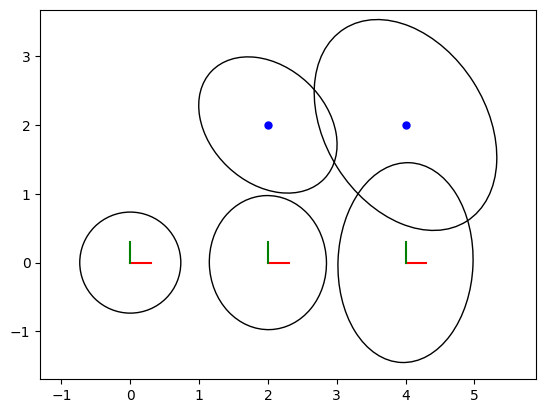

In [28]:
fig = plt.figure(2)
axes = fig.add_subplot()
axes = fig.axes[0]

# Plot 2D poses
poses = gtsam.utilities.allPose2s(result)
for key in poses.keys():
    pose = poses.atPose2(key)
    covariance = marginals.marginalCovariance(key)

    gp.plot_pose2_on_axes(axes, pose, covariance=covariance, axis_length=0.3)

# Plot 2D landmarks
landmarks: np.ndarray = gtsam.utilities.extractPoint2(result)  # 2xn array
for j, landmark in enumerate(landmarks):
    gp.plot_point2_on_axes(axes, landmark, linespec="b")
    covariance = marginals.marginalCovariance(L(j+1))
    gp.plot_covariance_ellipse_2d(axes, landmark, covariance=covariance)

axes.set_aspect("equal", adjustable="datalim")

## Summary

We have successfully:
1.  Defined the structure of a 2D SLAM problem using factors (prior, odometry, measurements) and variables (poses, landmarks).
2.  Represented this problem as a `gtsam.NonlinearFactorGraph`.
3.  Provided noisy measurements and an inaccurate initial estimate.
4.  Used `gtsam.LevenbergMarquardtOptimizer` to find the most likely configuration of poses and landmarks.
5.  Calculated the uncertainty (covariance) of the final estimates.

This demonstrates the basic workflow of using GTSAM for solving SLAM and other robotics estimation problems.